# Test 3
Austin Derrow-Pinion CM 208

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import time
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

#### Load data

In [2]:
CIFAR10 = np.load('./Data/CIFAR-10_plane_auto_ship_truck.npz')

label_names = CIFAR10['label_names']
images_train = CIFAR10['images_train']
labels_train = CIFAR10['labels_train']
images_valid = CIFAR10['images_valid']
labels_valid = CIFAR10['labels_valid']

print('CIFAR-10 plane, automobiles, ship, truck training and validation data set loaded.')
print('  training input:',images_train.shape,' output:',labels_train.shape)
print('validation input:',images_valid.shape,'  output:',labels_valid.shape)

CIFAR-10 plane, automobiles, ship, truck training and validation data set loaded.
  training input: (12000, 32, 32, 3)  output: (12000,)
validation input: (8000, 32, 32, 3)   output: (8000,)


In [3]:
inputs_train = images_train
inputs_valid = images_valid

#### Double training data set by flipping image

In [4]:
for image, label in zip(inputs_train, labels_train):
    inputs_train = np.append(inputs_train, [np.fliplr(image)], axis=0)
    labels_train = np.append(labels_train, label)

In [5]:
print('CIFAR-10 plane, automobiles, ship, truck training and validation data set loaded.')
print('  training input:',inputs_train.shape,' output:',labels_train.shape)
print('validation input:',inputs_valid.shape,'  output:',labels_valid.shape)

CIFAR-10 plane, automobiles, ship, truck training and validation data set loaded.
  training input: (24000, 32, 32, 3)  output: (24000,)
validation input: (8000, 32, 32, 3)   output: (8000,)


#### one-hot encode data

In [6]:
# one-hot-encode labels
outputs_train = OneHotEncoder(sparse=False).fit_transform(labels_train.reshape(-1,1))
outputs_valid = OneHotEncoder(sparse=False).fit_transform(labels_valid.reshape(-1,1))

print('Data reshaped, scaled and one-hot-encoded:')
print('   training input:',inputs_train.shape,' output:',outputs_train.shape)
print(' validation input:',inputs_valid.shape,' output:',outputs_valid.shape)

Data reshaped, scaled and one-hot-encoded:
   training input: (24000, 32, 32, 3)  output: (24000, 4)
 validation input: (8000, 32, 32, 3)  output: (8000, 4)


#### spot check

automobile 			 airplane


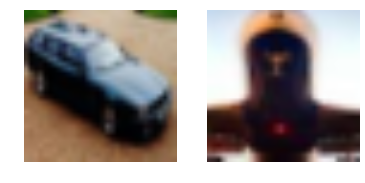

airplane 			 ship


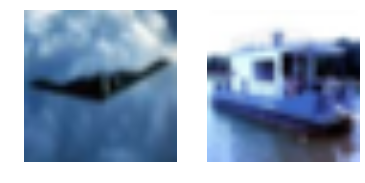

automobile 			 automobile


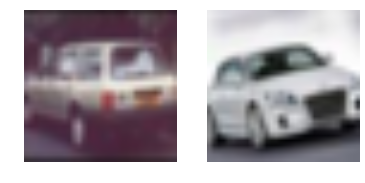

automobile 			 truck


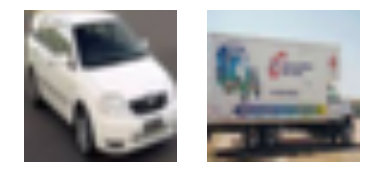

airplane 			 truck


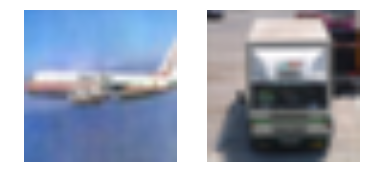

In [7]:
# spot check images and labels
SAMPLE_SIZE = 5
ix = np.random.randint(0,high=images_valid.shape[0],size=SAMPLE_SIZE)
for i in ix:
    plt.figure()
    plt.subplot(121)
    plt.axis('off')
    plt.imshow(images_train[i,:,:],interpolation=None)
    plt.subplot(122)
    plt.axis('off')
    plt.imshow(images_valid[i,:,:],interpolation=None)
    print('%s \t\t\t %s' % (label_names[labels_train[i]], label_names[labels_valid[i]]))
    plt.show()

#### check balance of data set

In [8]:
# check that A and B categories are balanced
df = pd.DataFrame()
df['labels'] = labels_train
df['names'] = label_names[labels_train]
print(df.shape)
df.head()

(24000, 2)


,labels,names
0,0,airplane
1,1,automobile
2,1,automobile
3,1,automobile
4,9,truck


In [9]:
df.names.value_counts()

truck         6000
airplane      6000
ship          6000
automobile    6000
Name: names, dtype: int64

#### Establish baseline accuracy rate using logistic regression

In [10]:
input_flat1 = np.reshape(np.array(inputs_train), [-1, 32*32*3])
input_flat2 = np.reshape(np.array(inputs_valid), [-1, 32*32*3])
LgR = LogisticRegression(solver='lbfgs',multi_class='multinomial')
LgR.fit(input_flat1, labels_train)
labels_train_pred = LgR.predict(input_flat1)
labels_valid_pred = LgR.predict(input_flat2)

In [11]:
acc_train = accuracy_score(labels_train, labels_train_pred)
acc_valid = accuracy_score(labels_valid, labels_valid_pred)

print("Baseline train error rate: {}".format(1.0 - acc_train))
print("Baseline valid error rate: {}".format(1.0 - acc_valid))

Baseline train error rate: 0.4021666666666667
Baseline valid error rate: 0.4175


#### Confusion matrix of baseline logistic regression predictions

In [12]:
print('confusion matrix: training')
CM = confusion_matrix(labels_train,labels_train_pred)
labels = label_names[[0,1,8,9]]
CM = pd.DataFrame(CM,index=labels,columns=labels)
CM['total'] = CM.sum(axis=1)
print(CM)

confusion matrix: training
            airplane  automobile  ship  truck  total
airplane        3668         560  1138    634   6000
automobile       640        3478   722   1160   6000
ship            1272         408  3672    648   6000
truck            638        1158   674   3530   6000


In [13]:
print('confusion matrix: validation')
CM = confusion_matrix(labels_valid,labels_valid_pred)
labels = label_names[[0,1,8,9]]
CM = pd.DataFrame(CM,index=labels,columns=labels)
CM['total'] = CM.sum(axis=1)
print(CM)

confusion matrix: validation
            airplane  automobile  ship  truck  total
airplane        1196         184   380    240   2000
automobile       231        1124   235    410   2000
ship             439         153  1192    216   2000
truck            215         394   243   1148   2000


#### Define hyper-parameters to overfit 100 images

In [29]:
EPOCHS = 40     # number of training epochs
N1 = 100        # training set size

PS1 = 4         # patch size
DEPTH1 = 32     # number of filters

PS2 = 4         # patch size
DEPTH2 = 32     # number of filters

LAM = 0         # regularization parameter
BS = 10         # batch size
STD = 0.01      # weight initialization standard deviation

#### Define TensorFlow computational graph

In [30]:
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3))
y = tf.placeholder(tf.float32, shape=(None, 4))

# input --> convolution layer 1
W1 = tf.Variable(tf.truncated_normal([PS1, PS1, 3, DEPTH1], stddev=STD))
B1 = tf.Variable(tf.truncated_normal([DEPTH1], stddev=STD))
y1 = tf.nn.relu(tf.nn.conv2d(x, W1, [1, 2, 2, 1], padding='SAME') + B1)

# convolution layer 1 --> convolution layer 2
W2 = tf.Variable(tf.truncated_normal([PS2, PS2, DEPTH1, DEPTH2], stddev=STD))
B2 = tf.Variable(tf.truncated_normal([DEPTH2], stddev=STD))
y2 = tf.nn.relu(tf.nn.conv2d(y1, W2, [1, 2, 2, 1], padding='SAME') + B2)

# convolution layer 2 --> fully connected layer 3
flat_shape = 8*8*DEPTH2
y2_flat = tf.reshape(y2, [-1, flat_shape])
W3 = tf.Variable(tf.truncated_normal([flat_shape, 4], stddev=STD))
B3 = tf.Variable(tf.truncated_normal([4], stddev=STD))
logits = tf.matmul(y2_flat, W3) + B3 # TODO: try to add a ReLU layer here
y_pred = tf.argmax(tf.nn.softmax(logits), 1)

# optimization and accuracy
L2 = tf.reduce_mean(tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3))
CE = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.AdamOptimizer().minimize(CE + (LAM * L2))
accuracy = 1.0 - tf.contrib.metrics.accuracy(y_pred, tf.argmax(y, 1))

In [31]:
def trainNetwork(sess, init):
    sess.run(init)
    
    labels_conversion = np.array([0, 1, 8, 9])
    t_start = time.time()
    num_data = N1
    num_batches = np.floor(num_data / BS)

    print()
    print('%15s%24s%24s' % (' ', 'cross-entropy', 'error-rate'))
    print('%15s%12s%12s%12s%12s%12s%12s' % ('epoch', 'training', 'validation', 'training', 'validation', 'L2', 'time (min)'))
    
    for epoch in np.arange(EPOCHS):
        perm = np.random.permutation(num_data)
        ix = np.arange(0, BS)
        epoch = epoch + 1
        for batch in np.arange(num_batches):
            x_batch = inputs_train[perm[ix], :]
            y_batch = outputs_train[perm[ix], :]
            sess.run([optimizer],feed_dict={x: x_batch, y: y_batch})
            ix = ix + BS
        if (epoch % (EPOCHS / 10)) == 0:
            ce_train, error_train, l2 = sess.run([CE, accuracy, L2], feed_dict={x: inputs_train[:N1], y: outputs_train[:N1]})
            ce_valid, error_valid = sess.run([CE, accuracy], feed_dict={x: inputs_valid, y: outputs_valid})
            total_compute_time = (time.time() - t_start)/60
            print('%7d %7d%12.5f%12.5f%12.3f%12.3g%12f%12.1f' % (EPOCHS,epoch,ce_train,ce_valid,error_train,error_valid,l2,total_compute_time))

In [32]:
init = tf.initialize_all_variables()
with tf.Session() as sess:
    trainNetwork(sess, init)


                          cross-entropy              error-rate
          epoch    training  validation    training  validation          L2  time (min)
     40       4     1.31218     1.41437       0.650        0.72    1.360348         0.0
     40       8     1.18500     1.54849       0.550       0.711    1.410463         0.0
     40      12     1.26551     1.32943       0.550       0.612    1.529183         0.0
     40      16     0.94081     1.49717       0.350       0.662    1.730393         0.0
     40      20     0.83593     1.94407       0.350       0.687    2.012786         0.0
     40      24     0.26084     1.95537       0.080       0.617    2.527060         0.1
     40      28     0.07095     2.54481       0.000       0.608    2.984370         0.1
     40      32     0.21875     3.34988       0.080       0.674    3.284973         0.1
     40      36     0.01308     4.05259       0.000       0.633    3.691669         0.1
     40      40     0.00189     4.50477       0.000    

#### Define hyper-parameters to minimize validation error

In [26]:
EPOCHS = 800   # number of training epochs
N1 = 24000     # training set size

PS1 = 4        # patch size
DEPTH1 = 128   # number of filters
STRIDE1 = 2

PS2 = 2        # patch size
DEPTH2 = 64    # number of filters
STRIDE2 = 2

LAM = 0.01     # regularization parameter
BS = 1000      # batch size
STD = 0.1      # weight initialization standard deviation

#### Define TensorFlow computational graph

In [27]:
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3))
y = tf.placeholder(tf.float32, shape=(None, 4))

# input --> convolution layer 1
W1 = tf.Variable(tf.truncated_normal([PS1, PS1, 3, DEPTH1], stddev=STD))
B1 = tf.Variable(tf.truncated_normal([DEPTH1], stddev=STD))
y1 = tf.nn.relu(tf.nn.conv2d(x, W1, [1, STRIDE1, STRIDE1, 1], padding='SAME') + B1)

# convolution layer 1 --> convolution layer 2
W2 = tf.Variable(tf.truncated_normal([PS2, PS2, DEPTH1, DEPTH2], stddev=STD))
B2 = tf.Variable(tf.truncated_normal([DEPTH2], stddev=STD))
y2 = tf.nn.relu(tf.nn.conv2d(y1, W2, [1, STRIDE2, STRIDE2, 1], padding='SAME') + B2)

# convolution layer 2 --> fully connected layer 3
flat_shape = int(((32 / STRIDE1) / STRIDE2) ** 2) * DEPTH2
y2_flat = tf.reshape(y2, [-1, flat_shape])
W3 = tf.Variable(tf.truncated_normal([flat_shape, 4], stddev=STD))
B3 = tf.Variable(tf.truncated_normal([4], stddev=STD))
logits = tf.matmul(y2_flat, W3) + B3
y_pred = tf.argmax(tf.nn.softmax(logits), 1)

# optimization and accuracy
L2 = tf.reduce_mean(tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3))
CE = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.AdamOptimizer().minimize(CE + (LAM * L2))
accuracy = 1.0 - tf.contrib.metrics.accuracy(y_pred, tf.argmax(y, 1))

In [28]:
init = tf.initialize_all_variables()
with tf.Session() as sess:
    trainNetwork(sess, init)


                          cross-entropy              error-rate
          epoch    training  validation    training  validation          L2  time (min)
    800      20     1.27211     1.29931       0.622       0.642  178.143219         1.7
    800      40     0.94960     1.02606       0.401       0.429  158.937943         3.5
    800      60     0.79011     0.88355       0.318       0.337  145.712555         6.1
    800      80     0.65345     0.79149       0.255        0.29  135.160156         8.6
    800     100     0.55397     0.72664       0.210       0.264  125.888763        11.1
    800     120     0.55025     0.76621       0.216       0.268  117.519905        14.7
    800     140     0.41931     0.69254       0.153       0.234  109.695084        16.9
    800     160     0.43550     0.75668       0.164       0.254  102.247604        18.6
    800     180     0.35282     0.75679       0.132       0.237   95.045578        20.3
    800     200     0.30483     0.73904       0.110    